# **青色領域検出と楕円フィッティングプログラム**

このPythonスクリプトは、マスク画像内の青色領域を検出し、その形状に最適な楕円をフィッティングするプログラムです。主な機能は以下の通りです：

1. OpenCV、NumPy、Matplotlib、Scikit-learnライブラリを使用
2. HSV色空間を使用して画像から青色領域を抽出
3. 主成分分析（PCA）を用いて青色ピクセルの分布から楕円をフィッティング
4. 楕円の中心座標、長軸・短軸の長さ、傾き角度を計算
5. 結果をYOLO形式の正規化座標で出力
6. 可視化機能による結果の確認

正確な青色検出のためにHSV色空間を使用し、モルフォロジー演算でノイズを除去しています。また、PCAを使用して点群の分布から最適な楕円のパラメータを算出しています。

Image size: 3000x1700


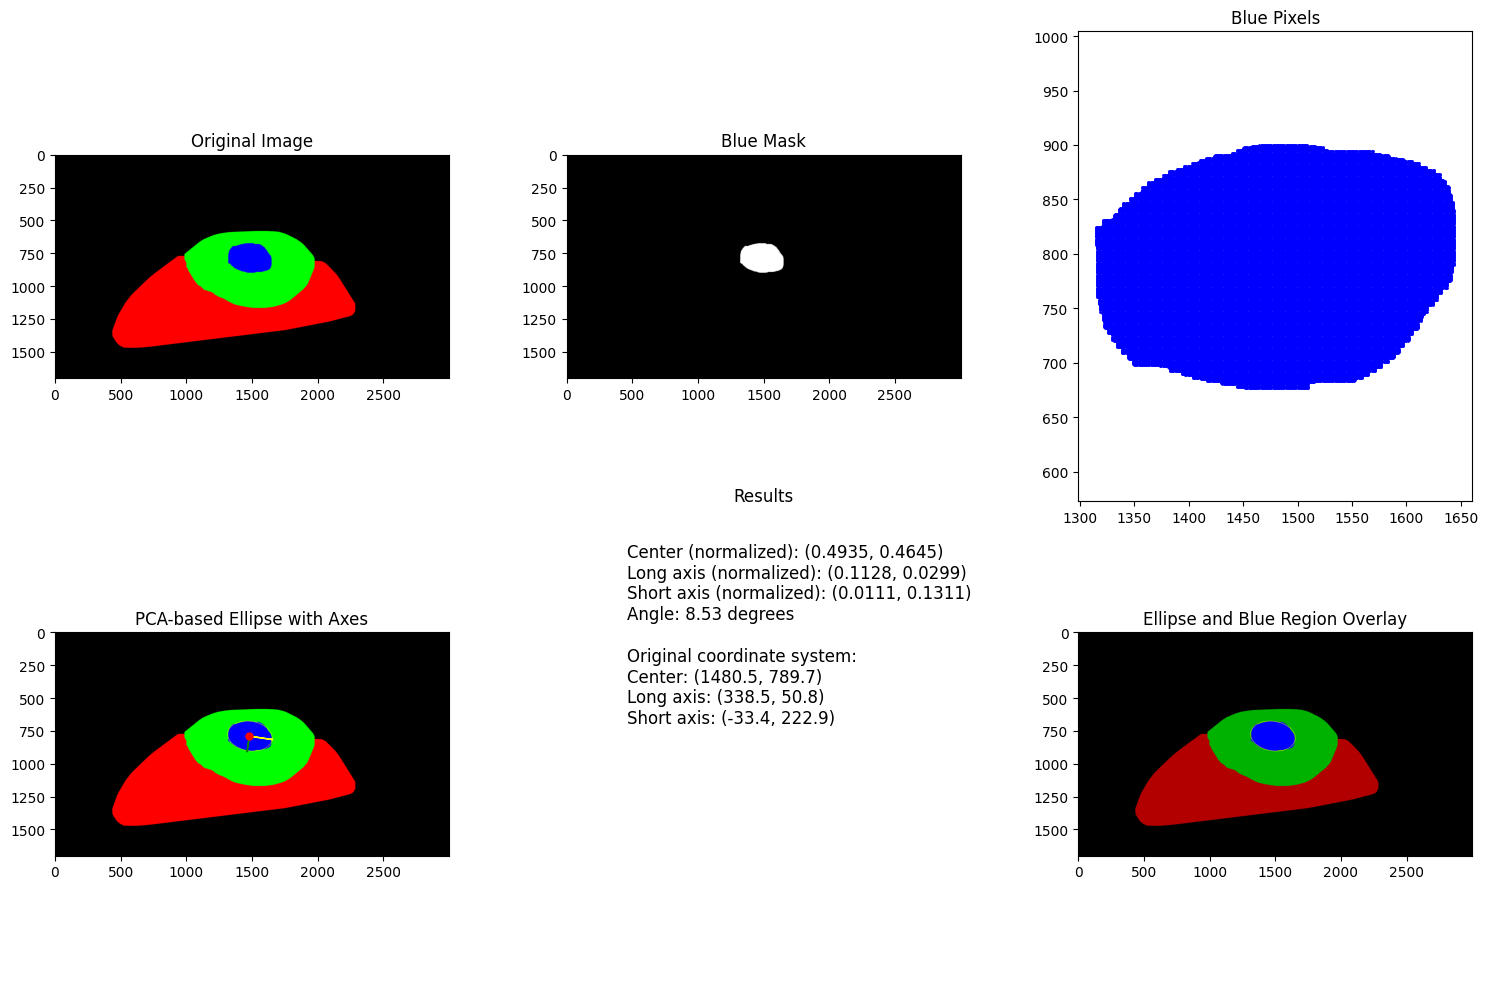

Center (normalized): (0.493502, 0.464503)
Long axis (normalized): (0.112830, 0.029869)
Short axis (normalized): (0.011145, 0.131113)
Angle: 8.53 degrees


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def extract_blue_and_fit_ellipse(image_path):
    # 画像を読み込む
    img = cv2.imread(image_path)
    
    # BGRからRGBに変換
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 画像のサイズを取得
    height, width = img.shape[:2]
    print(f"Image size: {width}x{height}")
    
    # 青色部分を抽出するためのマスクを作成
    # HSVでの青色の検出（より正確）
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # HSVでの青色の範囲を調整
    lower_blue_hsv = np.array([100, 100, 50])
    upper_blue_hsv = np.array([140, 255, 255])
    
    # HSVマスクを作成
    blue_mask = cv2.inRange(img_hsv, lower_blue_hsv, upper_blue_hsv)
    
    # ノイズ除去と輪郭の滑らかさ向上のためのモルフォロジー演算
    kernel = np.ones((5,5), np.uint8)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
    
    # 青色のピクセル座標を取得
    blue_pixels = np.where(blue_mask > 0)
    y_coords = blue_pixels[0]
    x_coords = blue_pixels[1]
    
    if len(x_coords) < 5:
        print("青色のピクセルが十分に検出できませんでした")
        return None
    
    # 座標点の配列を作成
    points = np.vstack((x_coords, y_coords)).T
    
    # PCAを使用して主成分を見つける（楕円の主軸方向）
    pca = PCA(n_components=2)
    pca.fit(points)
    
    # 中心座標（平均）
    cx, cy = np.mean(points, axis=0)
    
    # 固有値と固有ベクトル
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    # 長軸と短軸の長さ計算
    # 標準偏差の倍数で楕円の大きさを調整
    major_axis_length = 2 * np.sqrt(eigenvalues[0]) * 2.0  # 1.8σ - 小さく調整
    minor_axis_length = 2 * np.sqrt(eigenvalues[1]) * 2.0  # 1.8σ - 小さく調整
    
    # 角度計算（ラジアン）
    angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    
    # 角度を度に変換
    angle_deg = np.degrees(angle_rad) % 180
    
    # 長軸のx方向とy方向の長さ
    lx = major_axis_length * np.cos(angle_rad)
    ly = major_axis_length * np.sin(angle_rad)
    
    # 短軸のx方向とy方向の長さ
    sx = minor_axis_length * np.cos(angle_rad + np.pi/2)
    sy = minor_axis_length * np.sin(angle_rad + np.pi/2)
    
    # YOLO形式に正規化
    cx_norm = cx / width
    cy_norm = cy / height
    lx_norm = abs(lx) / width
    ly_norm = abs(ly) / height
    sx_norm = abs(sx) / width
    sy_norm = abs(sy) / height
    
    # 青色領域の輪郭を検出（表示用）
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # 結果を格納
    result = {
        "center": (cx_norm, cy_norm),
        "long_axis": (lx_norm, ly_norm),
        "short_axis": (sx_norm, sy_norm),
        "angle_degrees": angle_deg
    }
    
    # 視覚化
    plt.figure(figsize=(15, 10))
    
    # 元の画像
    plt.subplot(2, 3, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    
    # 青色マスク
    plt.subplot(2, 3, 2)
    plt.imshow(blue_mask, cmap='gray')
    plt.title('Blue Mask')
    
    # 点群プロット
    plt.subplot(2, 3, 3)
    plt.scatter(x_coords, y_coords, s=1, c='blue')
    plt.axis('equal')
    plt.title('Blue Pixels')
    
    # PCAによる楕円
    plt.subplot(2, 3, 4)
    img_ellipse = img_rgb.copy()
    
    # 楕円のパラメータ
    ellipse_center = (int(cx), int(cy))
    ellipse_axes = (int(major_axis_length/2), int(minor_axis_length/2))
    
    # 楕円を描画
    cv2.ellipse(img_ellipse, ellipse_center, ellipse_axes, 
               angle_deg, 0, 360, (255, 255, 0), 2)
    
    # 中心点
    plt.imshow(img_ellipse)
    plt.plot(cx, cy, 'ro', markersize=5)
    
    # 長軸と短軸を描画
    arrow_scale = 1.0
    plt.arrow(cx, cy, lx/2 * arrow_scale, ly/2 * arrow_scale, 
             color='yellow', width=2, head_width=10, head_length=10)
    plt.arrow(cx, cy, sx/2 * arrow_scale, sy/2 * arrow_scale, 
             color='green', width=2, head_width=10, head_length=10)
    plt.title('PCA-based Ellipse with Axes')
    
    # 結果テキスト
    plt.subplot(2, 3, 5)
    plt.axis('off')
    info_text = f"""
    Center (normalized): ({cx_norm:.4f}, {cy_norm:.4f})
    Long axis (normalized): ({lx_norm:.4f}, {ly_norm:.4f})
    Short axis (normalized): ({sx_norm:.4f}, {sy_norm:.4f})
    Angle: {angle_deg:.2f} degrees
    
    Original coordinate system:
    Center: ({cx:.1f}, {cy:.1f})
    Long axis: ({lx:.1f}, {ly:.1f})
    Short axis: ({sx:.1f}, {sy:.1f})
    """
    plt.text(0.1, 0.5, info_text, fontsize=12)
    plt.title('Results')
    
    # 比較表示：楕円と青色マスクのオーバーレイ
    plt.subplot(2, 3, 6)
    overlay = img_rgb.copy()
    
    # マスクを半透明で表示
    mask_rgb = cv2.cvtColor(blue_mask, cv2.COLOR_GRAY2RGB)
    mask_overlay = np.zeros_like(overlay)
    mask_overlay[blue_mask > 0] = [0, 0, 255]  # 青色
    
    # 透明度を設定
    alpha = 0.3
    overlay = cv2.addWeighted(overlay, 1-alpha, mask_overlay, alpha, 0)
    
    # 楕円を描画
    cv2.ellipse(overlay, ellipse_center, ellipse_axes, 
               angle_deg, 0, 360, (255, 255, 0), 2)
    
    plt.imshow(overlay)
    plt.title('Ellipse and Blue Region Overlay')
    
    plt.tight_layout()
    plt.show()
    
    # 結果を出力
    print(f"Center (normalized): ({cx_norm:.6f}, {cy_norm:.6f})")
    print(f"Long axis (normalized): ({lx_norm:.6f}, {ly_norm:.6f})")
    print(f"Short axis (normalized): ({sx_norm:.6f}, {sy_norm:.6f})")
    print(f"Angle: {angle_deg:.2f} degrees")
    
    return result

if __name__ == "__main__":
    # 画像のパスを指定
    image_path = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\MOBIUS\Masks\19\19_1i_Lu_1.png"  # 実際の画像パスに変更してください
    result = extract_blue_and_fit_ellipse(image_path)

# 青色領域検出と楕円フィッティングプログラム - 詳細解説

このPythonスクリプトは、画像内の青色領域を検出し、その形状に最適な楕円をフィッティングするプログラムです。さらに、バッチ処理機能が追加され、複数の画像を一度に処理できるように拡張されています。

## 主な機能

1. **青色領域検出**: HSV色空間を使用して画像から青色領域を正確に抽出
2. **楕円フィッティング**: 主成分分析（PCA）を用いて青色ピクセルの分布から最適な楕円を計算
3. **パラメータ計算**: 楕円の中心座標、長軸・短軸の長さ、傾き角度を算出
4. **YOLO形式出力**: 結果をYOLO互換の正規化座標でテキストファイルに保存
5. **バッチ処理**: ディレクトリ内の複数画像を再帰的に処理
6. **カスタマイズ**: 楕円サイズの調整パラメータ（sigma）、可視化オプションなど

## 技術的詳細

### 使用ライブラリ
- OpenCV: 画像処理、色空間変換、モルフォロジー演算
- NumPy: 数値計算、行列操作
- Matplotlib: 結果の可視化
- Scikit-learn: 主成分分析（PCA）による楕円フィッティング

### 処理の流れ

1. **画像読み込み**: OpenCVで画像を読み込み、BGR→RGB変換
2. **青色検出**: HSV色空間で青色の範囲を指定し、マスク画像を生成
3. **ノイズ除去**: オープニング・クロージング処理で青色マスクのノイズを除去
4. **座標抽出**: 青色ピクセルの座標を取得
5. **PCA適用**: 点群に主成分分析を適用し、分布の主軸を算出
6. **楕円パラメータ計算**: 
   - 中心座標: 点群の平均値
   - 軸の長さ: 固有値を用いて計算（標準偏差×sigma倍）
   - 角度: 固有ベクトルから計算
7. **正規化**: パラメータを画像サイズで正規化（YOLO形式）
8. **結果出力**: テキストファイルへの保存（クラス, cx, cy, l, s, angle形式）
9. **可視化**: オプションでプロセスと結果を視覚的に表示

### 改良点

- バッチ処理機能の追加（複数画像の一括処理）
- 関数のドキュメント化（docstring）
- エラーハンドリングの強化
- フォルダ構造を保持した出力
- カスタマイズオプションの追加
- 処理の進捗表示

## 使用方法

```python
# 単一画像の処理
result = extract_blue_and_fit_ellipse(
    image_path="path/to/image.png",
    save_path="path/to/output.txt",
    sigma=2.0,  # 楕円サイズの調整係数
    visualize=True  # 結果を可視化
)

# ディレクトリの一括処理
process_directory(
    orig_dir="path/to/images",
    dst_dir="path/to/outputs",
    sigma=2.0,
    visualize=False
)
```

## 出力形式

テキストファイルの各行は以下の形式で出力されます:
```
0 cx cy l s angle
```

- `0`: クラスID（固定値）
- `cx, cy`: 楕円の中心座標（正規化）
- `l`: 長軸の長さ（正規化）
- `s`: 短軸の長さ（正規化）
- `angle`: 楕円の傾き角度（度）

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob

def extract_blue_and_fit_ellipse(image_path, save_path=None, sigma=2.0, visualize=False):
    """
    画像から青色領域を抽出し、PCAを使って楕円近似を行う関数
    
    Parameters:
    -----------
    image_path : str
        処理する画像のパス
    save_path : str, optional
        結果を保存するテキストファイルのパス
    sigma : float, optional
        楕円サイズの標準偏差倍率 (デフォルト: 2.0)
    visualize : bool, optional
        結果を可視化するかどうか (デフォルト: False)
    
    Returns:
    --------
    dict or None
        処理結果の辞書、エラーの場合はNone
    """
    try:
        # 画像を読み込む
        img = cv2.imread(image_path)
        if img is None:
            print(f"画像が読み込めませんでした: {image_path}")
            return None
        
        # BGRからRGBに変換
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 画像のサイズを取得
        height, width = img.shape[:2]
        
        # 青色部分を抽出するためのマスクを作成
        # HSVでの青色の検出（より正確）
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # HSVでの青色の範囲を調整
        lower_blue_hsv = np.array([100, 100, 50])
        upper_blue_hsv = np.array([140, 255, 255])
        
        # HSVマスクを作成
        blue_mask = cv2.inRange(img_hsv, lower_blue_hsv, upper_blue_hsv)
        
        # ノイズ除去と輪郭の滑らかさ向上のためのモルフォロジー演算
        kernel = np.ones((5,5), np.uint8)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
        
        # 青色のピクセル座標を取得
        blue_pixels = np.where(blue_mask > 0)
        y_coords = blue_pixels[0]
        x_coords = blue_pixels[1]
        
        if len(x_coords) < 5:
            print(f"青色のピクセルが十分に検出できませんでした: {image_path}")
            return None
        
        # 座標点の配列を作成
        points = np.vstack((x_coords, y_coords)).T
        
        # PCAを使用して主成分を見つける（楕円の主軸方向）
        pca = PCA(n_components=2)
        pca.fit(points)
        
        # 中心座標（平均）
        cx, cy = np.mean(points, axis=0)
        
        # 固有値と固有ベクトル
        eigenvalues = pca.explained_variance_
        eigenvectors = pca.components_
        
        # 長軸と短軸の長さ計算
        # sigmaパラメータを使用して標準偏差の倍数を調整
        major_axis_length = 2 * np.sqrt(eigenvalues[0]) * sigma
        minor_axis_length = 2 * np.sqrt(eigenvalues[1]) * sigma
        
        # 角度計算（ラジアン）
        angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
        
        # 角度を度に変換
        angle_deg = np.degrees(angle_rad) % 180
        
        # 長軸のx方向とy方向の長さ
        lx = major_axis_length * np.cos(angle_rad)
        ly = major_axis_length * np.sin(angle_rad)
        
        # 短軸のx方向とy方向の長さ
        sx = minor_axis_length * np.cos(angle_rad + np.pi/2)
        sy = minor_axis_length * np.sin(angle_rad + np.pi/2)
        
        # YOLO形式に正規化
        cx_norm = cx / width
        cy_norm = cy / height
        lx_norm = abs(lx) / width
        ly_norm = abs(ly) / height
        sx_norm = abs(sx) / width
        sy_norm = abs(sy) / height
        
        # 長軸と短軸の長さを計算（正規化）
        l_norm = np.sqrt(lx_norm**2 + ly_norm**2)
        s_norm = np.sqrt(sx_norm**2 + sy_norm**2)
        
        # 別の方法で計算する場合は以下を使用
        # l_norm = major_axis_length / width  # 長軸の長さを直接正規化
        # s_norm = minor_axis_length / height  # 短軸の長さを直接正規化
        
        # 結果を格納
        result = {
            "center": (cx_norm, cy_norm),
            "long_axis": (lx_norm, ly_norm),
            "short_axis": (sx_norm, sy_norm),
            "angle_degrees": angle_deg
        }
        
        # 可視化が有効な場合
        if visualize:
            plt.figure(figsize=(15, 10))
            
            # 元の画像
            plt.subplot(2, 2, 1)
            plt.imshow(img_rgb)
            plt.title('Original Image')
            
            # 青色マスク
            plt.subplot(2, 2, 2)
            plt.imshow(blue_mask, cmap='gray')
            plt.title('Blue Mask')
            
            # PCAによる楕円
            plt.subplot(2, 2, 3)
            img_ellipse = img_rgb.copy()
            
            # 楕円のパラメータ
            ellipse_center = (int(cx), int(cy))
            ellipse_axes = (int(major_axis_length/2), int(minor_axis_length/2))
            
            # 楕円を描画
            cv2.ellipse(img_ellipse, ellipse_center, ellipse_axes, 
                       angle_deg, 0, 360, (255, 255, 0), 2)
            
            # 中心点
            plt.imshow(img_ellipse)
            plt.plot(cx, cy, 'ro', markersize=5)
            
            # 長軸と短軸を描画
            arrow_scale = 1.0
            plt.arrow(cx, cy, lx/2 * arrow_scale, ly/2 * arrow_scale, 
                     color='yellow', width=2, head_width=10, head_length=10)
            plt.arrow(cx, cy, sx/2 * arrow_scale, sy/2 * arrow_scale, 
                     color='green', width=2, head_width=10, head_length=10)
            plt.title('PCA-based Ellipse with Axes')
            
            # 比較表示：楕円と青色マスクのオーバーレイ
            plt.subplot(2, 2, 4)
            overlay = img_rgb.copy()
            
            # マスクを半透明で表示
            mask_overlay = np.zeros_like(overlay)
            mask_overlay[blue_mask > 0] = [0, 0, 255]  # 青色
            
            # 透明度を設定
            alpha = 0.3
            overlay = cv2.addWeighted(overlay, 1-alpha, mask_overlay, alpha, 0)
            
            # 楕円を描画
            cv2.ellipse(overlay, ellipse_center, ellipse_axes, 
                       angle_deg, 0, 360, (255, 255, 0), 2)
            
            plt.imshow(overlay)
            plt.title('Ellipse and Blue Region Overlay')
            
            plt.tight_layout()
            plt.show()
        
        # テキストファイルへの保存が有効な場合
        if save_path:
            # 出力形式: クラス, cx, cy, l, s, ax
            # l: 長軸の長さ (正規化)
            # s: 短軸の長さ (正規化)
            # ax: 回転角度 (度数法)
            
            # 長軸と短軸の長さ
            # 実際の画像サイズで直接正規化する方が精度が高い
            l_norm = major_axis_length / max(width, height)  # 長軸の長さを最大辺で正規化
            s_norm = minor_axis_length / max(width, height)  # 短軸の長さを最大辺で正規化
            
            with open(save_path, 'w') as f:
                f.write(f"0 {cx_norm:.6f} {cy_norm:.6f} {l_norm:.6f} {s_norm:.6f} {angle_deg:.6f}\n")
            print(f"結果を保存しました: {save_path}")
        
        return result
    
    except Exception as e:
        print(f"エラーが発生しました ({image_path}): {str(e)}")
        return None

def process_directory(orig_dir, dst_dir, sigma=2.0, visualize=False):
    """
    ディレクトリ内の画像を処理し、結果をテキストファイルに保存する関数
    """
    # 出力ディレクトリが存在しない場合は作成
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        print(f"出力ディレクトリを作成しました: {dst_dir}")
    
    # サポートされる画像形式
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp']
    
    # 画像ファイルのパスをすべて取得
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(orig_dir, '**', ext), recursive=True))
    
    print(f"処理する画像ファイル数: {len(image_files)}")
    
    # 各画像を処理
    successful = 0
    failed = 0
    
    for i, image_path in enumerate(image_files):
        # ファイル名のみを取得（パスなし）
        file_name = os.path.basename(image_path)
        base_name = os.path.splitext(file_name)[0]
        
        # 出力ファイルのパスを作成（拡張子をtxtに変更）
        output_path = os.path.join(dst_dir, base_name + '.txt')
        
        # 進捗表示
        print(f"処理中 ({i+1}/{len(image_files)}): {file_name}")
        
        # 画像を処理
        result = extract_blue_and_fit_ellipse(image_path, output_path, sigma, visualize)
        
        if result:
            successful += 1
        else:
            failed += 1
    
    # 結果の要約を表示
    print(f"\n処理完了: 成功={successful}, 失敗={failed}, 合計={len(image_files)}")
    print(f"出力形式: クラス(0), 中心x, 中心y, 長軸長さ, 短軸長さ, 回転角度(度)")

if __name__ == "__main__":
    # 処理するディレクトリのパス（実際のパスに変更）
    orig_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\MOBIUS\Masks"  # 入力画像のディレクトリ
    dst_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\labels"     # 出力テキストファイルのディレクトリ
    
    # デフォルトの標準偏差倍率
    sigma = 2.0
    
    # 可視化オプション（Trueにすると各画像の処理結果を表示）
    visualize = False
    
    # 処理を実行
    process_directory(orig_dir, dst_dir, sigma, visualize)

処理する画像ファイル数: 3559
処理中 (1/3559): 1_1i_Ll_1.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ll_1.txt
処理中 (2/3559): 1_1i_Ll_2.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ll_2.txt
処理中 (3/3559): 1_1i_Lr_1.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lr_1.txt
処理中 (4/3559): 1_1i_Lr_2.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lr_2.txt
処理中 (5/3559): 1_1i_Ls_1.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ls_1.txt
処理中 (6/3559): 1_1i_Ls_2.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ls_2.txt
処理中 (7/3559): 1_1i_Lu_1.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lu_1.txt
処理中 (8/3559): 1_1i_Lu_2.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lu_2.txt
処理中 (9/3559): 1_1i_Rl_1.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Rl_1.txt
処理中 (10/3559): 1_1i_Rl_2.png
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified

# **青色領域抽出とPCAを用いた楕円フィッティング(OBB形式)**

このコードは画像処理を行い、青色の領域を抽出して主成分分析（PCA）を用いた向き付き境界ボックス（OBB）を生成します。主な機能と処理の流れは以下の通りです：

## 主な機能
- 画像から青色部分を抽出
- 主成分分析（PCA）を使用して青色領域を近似する楕円を計算
- 向き付き境界ボックス（OBB）の生成
- YOLO OBB形式でのデータ出力
- 処理結果の視覚化

## 処理の流れ
1. **画像読み込みと前処理**
   - 画像をBGR形式で読み込み、RGB形式に変換
   - HSV色空間で青色を検出するためのマスクを作成
   - モルフォロジー演算でノイズを除去

2. **青色ピクセルの解析**
   - 青色ピクセルの座標を抽出
   - 抽出した点群に対してPCAを適用
   - 主成分から楕円の主軸方向と長さを決定

3. **楕円とOBBの計算**
   - 楕円の中心、長軸、短軸、角度を計算
   - OBBの4つの角点を計算
   - 座標を画像サイズで正規化（0〜1の範囲に）

4. **結果の出力**
   - YOLO OBB形式の文字列を生成
   - 結果を視覚化するための図を作成
   - 元画像、マスク、点群、OBB、結果情報を表示

## 技術的な特徴
- HSV色空間での色検出により正確な青色抽出を実現
- PCAにより点群の分布に最も適した楕円を計算
- 標準偏差の2倍を使用して楕円サイズを調整
- 結果は実座標系とYOLO互換の正規化座標系の両方で提供

## 出力形式
1. **辞書形式の結果**
   - `center`: 中心点の座標 (cx, cy)
   - `center_norm`: 正規化された中心点の座標 (cx/width, cy/height)
   - `OBB_corners`: OBBの4つの角点座標 [corner1, corner2, corner3, corner4]
   - `OBB_corners_norm`: 正規化されたOBBの4つの角点座標
   - `angle_degrees`: 楕円の角度（度）
   - `yolo_obb_line`: YOLO OBB形式の文字列

2. **YOLO OBB形式の文字列**
   - フォーマット: `cls x1 y1 x2 y2 x3 y3 x4 y4`
   - `cls`: クラスID（このコードでは常に0）
   - `(x1, y1)`, `(x2, y2)`, `(x3, y3)`, `(x4, y4)`: 正規化されたOBBの4つの角点座標

3. **視覚化結果**
   - 元の画像
   - 青色マスク
   - 青色ピクセルの点群プロット
   - PCAに基づく楕円とOBB
   - 結果テキスト情報
   - OBBと青色領域のオーバーレイ表示

このコードは、物体検出やセグメンテーションのデータセット作成、特に回転した物体のアノテーションに役立ちます。

Image size: 3000x1700


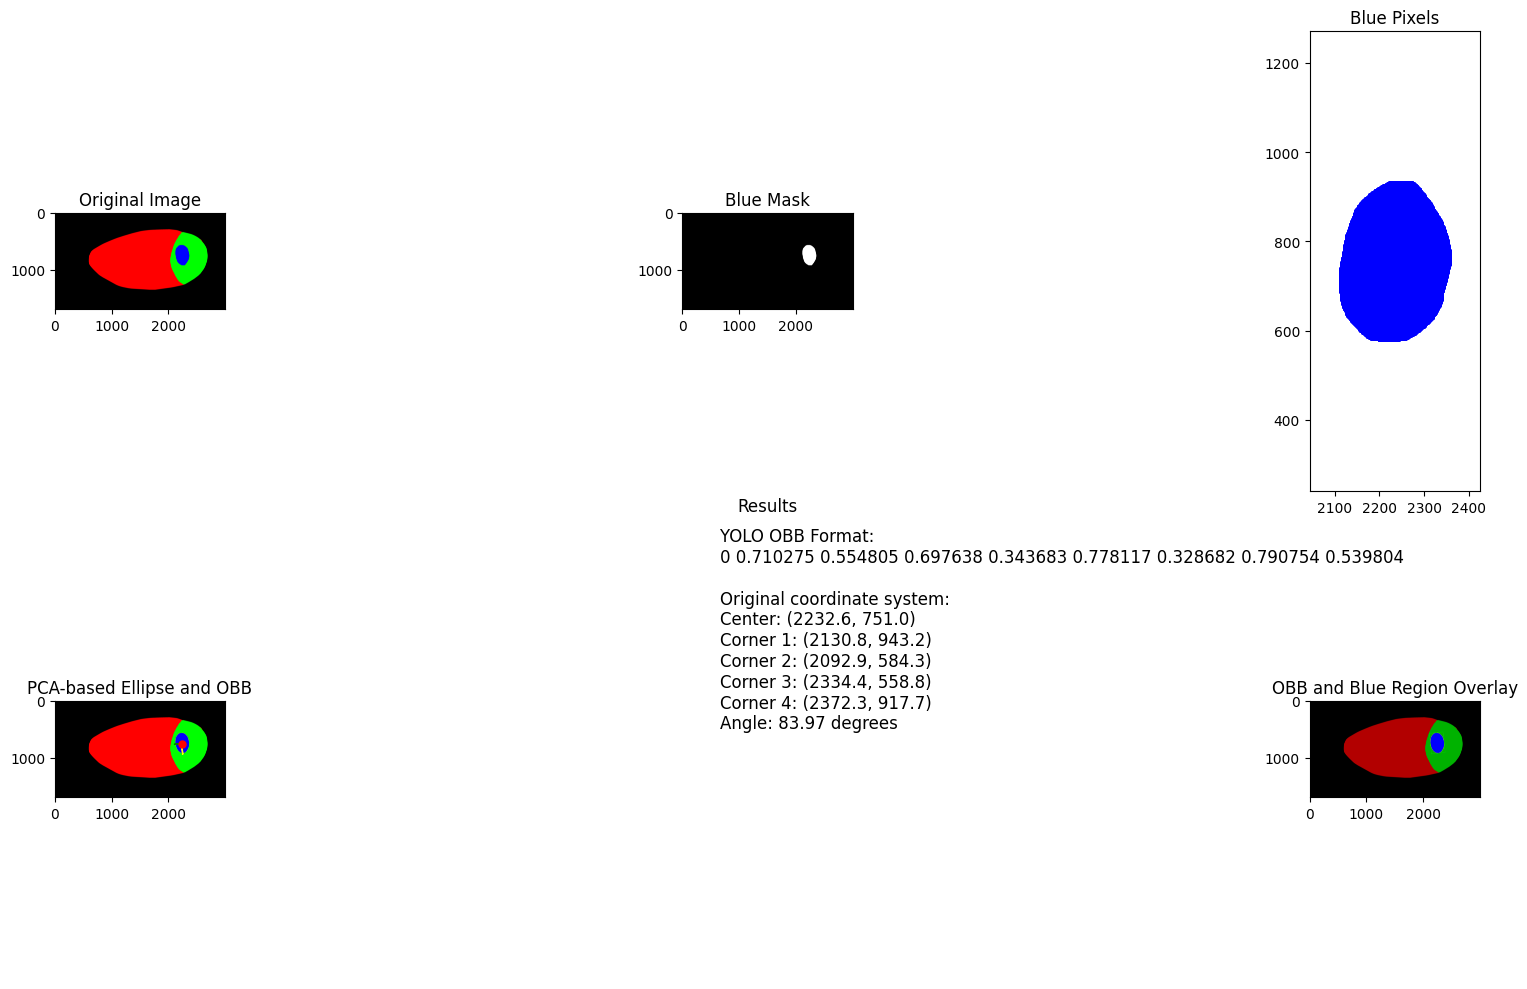

YOLO OBB Format:
0 0.710275 0.554805 0.697638 0.343683 0.778117 0.328682 0.790754 0.539804


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def extract_blue_and_fit_ellipse_to_obb(image_path):
    # 画像を読み込む
    img = cv2.imread(image_path)
    
    # BGRからRGBに変換
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 画像のサイズを取得
    height, width = img.shape[:2]
    print(f"Image size: {width}x{height}")
    
    # 青色部分を抽出するためのマスクを作成
    # HSVでの青色の検出（より正確）
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # HSVでの青色の範囲を調整
    lower_blue_hsv = np.array([100, 100, 50])
    upper_blue_hsv = np.array([140, 255, 255])
    
    # HSVマスクを作成
    blue_mask = cv2.inRange(img_hsv, lower_blue_hsv, upper_blue_hsv)
    
    # ノイズ除去と輪郭の滑らかさ向上のためのモルフォロジー演算
    kernel = np.ones((5,5), np.uint8)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
    
    # 青色のピクセル座標を取得
    blue_pixels = np.where(blue_mask > 0)
    y_coords = blue_pixels[0]
    x_coords = blue_pixels[1]
    
    if len(x_coords) < 5:
        print("青色のピクセルが十分に検出できませんでした")
        return None
    
    # 座標点の配列を作成
    points = np.vstack((x_coords, y_coords)).T
    
    # PCAを使用して主成分を見つける（楕円の主軸方向）
    pca = PCA(n_components=2)
    pca.fit(points)
    
    # 中心座標（平均）
    cx, cy = np.mean(points, axis=0)
    
    # 固有値と固有ベクトル
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    # 長軸と短軸の長さ計算
    # 標準偏差の倍数で楕円の大きさを調整
    major_axis_length = 2 * np.sqrt(eigenvalues[0]) * 2.0  # 2.0σ
    minor_axis_length = 2 * np.sqrt(eigenvalues[1]) * 2.0  # 2.0σ
    
    # 角度計算（ラジアン）
    angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    
    # 角度を度に変換
    angle_deg = np.degrees(angle_rad) % 180
    
    # 長軸のx方向とy方向の長さ
    lx = major_axis_length * np.cos(angle_rad)
    ly = major_axis_length * np.sin(angle_rad)
    
    # 短軸のx方向とy方向の長さ
    sx = minor_axis_length * np.cos(angle_rad + np.pi/2)
    sy = minor_axis_length * np.sin(angle_rad + np.pi/2)
    
    # OBB（Oriented Bounding Box）の4つの角点を計算
    # ここでは長方形の座標を計算（長軸と短軸の半分を使用）
    half_lx = lx / 2
    half_ly = ly / 2
    half_sx = sx / 2
    half_sy = sy / 2
    
    # 4つの角点座標
    corner1 = (cx + half_lx + half_sx, cy + half_ly + half_sy)
    corner2 = (cx - half_lx + half_sx, cy - half_ly + half_sy)
    corner3 = (cx - half_lx - half_sx, cy - half_ly - half_sy)
    corner4 = (cx + half_lx - half_sx, cy + half_ly - half_sy)
    
    # ピクセル座標を正規化
    x1_norm, y1_norm = corner1[0] / width, corner1[1] / height
    x2_norm, y2_norm = corner2[0] / width, corner2[1] / height
    x3_norm, y3_norm = corner3[0] / width, corner3[1] / height
    x4_norm, y4_norm = corner4[0] / width, corner4[1] / height
    
    # 値が0〜1の範囲内に収まるように制限
    x1_norm = np.clip(x1_norm, 0, 1)
    y1_norm = np.clip(y1_norm, 0, 1)
    x2_norm = np.clip(x2_norm, 0, 1)
    y2_norm = np.clip(y2_norm, 0, 1)
    x3_norm = np.clip(x3_norm, 0, 1)
    y3_norm = np.clip(y3_norm, 0, 1)
    x4_norm = np.clip(x4_norm, 0, 1)
    y4_norm = np.clip(y4_norm, 0, 1)
    
    # YOLO OBB 形式の文字列を作成
    # cls x1 y1 x2 y2 x3 y3 x4 y4
    obb_line = f"0 {x1_norm:.6f} {y1_norm:.6f} {x2_norm:.6f} {y2_norm:.6f} {x3_norm:.6f} {y3_norm:.6f} {x4_norm:.6f} {y4_norm:.6f}"
    
    # 青色領域の輪郭を検出（表示用）
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # 結果を格納
    result = {
        "center": (cx, cy),
        "center_norm": (cx / width, cy / height),
        "OBB_corners": [corner1, corner2, corner3, corner4],
        "OBB_corners_norm": [(x1_norm, y1_norm), (x2_norm, y2_norm), (x3_norm, y3_norm), (x4_norm, y4_norm)],
        "angle_degrees": angle_deg,
        "yolo_obb_line": obb_line
    }
    
    # 視覚化
    plt.figure(figsize=(15, 10))
    
    # 元の画像
    plt.subplot(2, 3, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    
    # 青色マスク
    plt.subplot(2, 3, 2)
    plt.imshow(blue_mask, cmap='gray')
    plt.title('Blue Mask')
    
    # 点群プロット
    plt.subplot(2, 3, 3)
    plt.scatter(x_coords, y_coords, s=1, c='blue')
    plt.axis('equal')
    plt.title('Blue Pixels')
    
    # PCAによる楕円とOBB
    plt.subplot(2, 3, 4)
    img_ellipse = img_rgb.copy()
    
    # 楕円のパラメータ
    ellipse_center = (int(cx), int(cy))
    ellipse_axes = (int(major_axis_length/2), int(minor_axis_length/2))
    
    # 楕円を描画
    cv2.ellipse(img_ellipse, ellipse_center, ellipse_axes, 
               angle_deg, 0, 360, (255, 255, 0), 2)
    
    # OBBを描画
    corners = np.array([corner1, corner2, corner3, corner4], dtype=np.int32)
    cv2.polylines(img_ellipse, [corners], True, (0, 255, 0), 2)
    
    # 中心点
    plt.imshow(img_ellipse)
    plt.plot(cx, cy, 'ro', markersize=5)
    
    # 長軸と短軸を描画
    arrow_scale = 1.0
    plt.arrow(cx, cy, lx/2 * arrow_scale, ly/2 * arrow_scale, 
             color='yellow', width=2, head_width=10, head_length=10)
    plt.arrow(cx, cy, sx/2 * arrow_scale, sy/2 * arrow_scale, 
             color='green', width=2, head_width=10, head_length=10)
    plt.title('PCA-based Ellipse and OBB')
    
    # 結果テキスト
    plt.subplot(2, 3, 5)
    plt.axis('off')
    info_text = f"""
    YOLO OBB Format:
    {obb_line}
    
    Original coordinate system:
    Center: ({cx:.1f}, {cy:.1f})
    Corner 1: ({corner1[0]:.1f}, {corner1[1]:.1f})
    Corner 2: ({corner2[0]:.1f}, {corner2[1]:.1f})
    Corner 3: ({corner3[0]:.1f}, {corner3[1]:.1f})
    Corner 4: ({corner4[0]:.1f}, {corner4[1]:.1f})
    Angle: {angle_deg:.2f} degrees
    """
    plt.text(0.1, 0.5, info_text, fontsize=12)
    plt.title('Results')
    
    # 比較表示：OBBと青色マスクのオーバーレイ
    plt.subplot(2, 3, 6)
    overlay = img_rgb.copy()
    
    # マスクを半透明で表示
    mask_rgb = cv2.cvtColor(blue_mask, cv2.COLOR_GRAY2RGB)
    mask_overlay = np.zeros_like(overlay)
    mask_overlay[blue_mask > 0] = [0, 0, 255]  # 青色
    
    # 透明度を設定
    alpha = 0.3
    overlay = cv2.addWeighted(overlay, 1-alpha, mask_overlay, alpha, 0)
    
    # 楕円を描画
    cv2.ellipse(overlay, ellipse_center, ellipse_axes, 
               angle_deg, 0, 360, (255, 255, 0), 2)
    
    # OBBを描画
    cv2.polylines(overlay, [corners], True, (0, 255, 0), 2)
    
    plt.imshow(overlay)
    plt.title('OBB and Blue Region Overlay')
    
    plt.tight_layout()
    plt.show()
    
    # 結果を出力
    print("YOLO OBB Format:")
    print(obb_line)
    
    return result

if __name__ == "__main__":
    # 画像のパスを指定
    image_path = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\MOBIUS\Masks\4\4_1i_Rl_2.png"  # 実際の画像パスに変更してください
    result = extract_blue_and_fit_ellipse_to_obb(image_path)

In [27]:
##フォルダごと一括処理

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob

def extract_blue_and_fit_ellipse_to_obb(image_path, save_path=None, visualize=False):
    """
    画像から青色領域を抽出し、PCAを使ってOBB（向き付き境界ボックス）を生成する関数
    
    Parameters:
    -----------
    image_path : str
        処理する画像のパス
    save_path : str, optional
        結果を保存するテキストファイルのパス
    visualize : bool, optional
        結果を可視化するかどうか (デフォルト: False)
    
    Returns:
    --------
    dict or None
        処理結果の辞書、エラーの場合はNone
    """
    try:
        # 画像を読み込む
        img = cv2.imread(image_path)
        if img is None:
            print(f"画像が読み込めませんでした: {image_path}")
            return None
        
        # BGRからRGBに変換
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 画像のサイズを取得
        height, width = img.shape[:2]
        print(f"Image size: {width}x{height}")
        
        # 青色部分を抽出するためのマスクを作成
        # HSVでの青色の検出（より正確）
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # HSVでの青色の範囲を調整
        lower_blue_hsv = np.array([100, 100, 50])
        upper_blue_hsv = np.array([140, 255, 255])
        
        # HSVマスクを作成
        blue_mask = cv2.inRange(img_hsv, lower_blue_hsv, upper_blue_hsv)
        
        # ノイズ除去と輪郭の滑らかさ向上のためのモルフォロジー演算
        kernel = np.ones((5,5), np.uint8)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
        
        # 青色のピクセル座標を取得
        blue_pixels = np.where(blue_mask > 0)
        y_coords = blue_pixels[0]
        x_coords = blue_pixels[1]
        
        if len(x_coords) < 5:
            print(f"青色のピクセルが十分に検出できませんでした: {image_path}")
            return None
        
        # 座標点の配列を作成
        points = np.vstack((x_coords, y_coords)).T
        
        # PCAを使用して主成分を見つける（楕円の主軸方向）
        pca = PCA(n_components=2)
        pca.fit(points)
        
        # 中心座標（平均）
        cx, cy = np.mean(points, axis=0)
        
        # 固有値と固有ベクトル
        eigenvalues = pca.explained_variance_
        eigenvectors = pca.components_
        
        # 長軸と短軸の長さ計算
        # 標準偏差の倍数で楕円の大きさを調整
        major_axis_length = 2 * np.sqrt(eigenvalues[0]) * 2.0  # 2.0σ
        minor_axis_length = 2 * np.sqrt(eigenvalues[1]) * 2.0  # 2.0σ
        
        # 角度計算（ラジアン）
        angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
        
        # 角度を度に変換
        angle_deg = np.degrees(angle_rad) % 180
        
        # 長軸のx方向とy方向の長さ
        lx = major_axis_length * np.cos(angle_rad)
        ly = major_axis_length * np.sin(angle_rad)
        
        # 短軸のx方向とy方向の長さ
        sx = minor_axis_length * np.cos(angle_rad + np.pi/2)
        sy = minor_axis_length * np.sin(angle_rad + np.pi/2)
        
        # OBB（Oriented Bounding Box）の4つの角点を計算
        # ここでは長方形の座標を計算（長軸と短軸の半分を使用）
        half_lx = lx / 2
        half_ly = ly / 2
        half_sx = sx / 2
        half_sy = sy / 2
        
        # 4つの角点座標
        corner1 = (cx + half_lx + half_sx, cy + half_ly + half_sy)
        corner2 = (cx - half_lx + half_sx, cy - half_ly + half_sy)
        corner3 = (cx - half_lx - half_sx, cy - half_ly - half_sy)
        corner4 = (cx + half_lx - half_sx, cy + half_ly - half_sy)
        
        # ピクセル座標を正規化
        x1_norm, y1_norm = corner1[0] / width, corner1[1] / height
        x2_norm, y2_norm = corner2[0] / width, corner2[1] / height
        x3_norm, y3_norm = corner3[0] / width, corner3[1] / height
        x4_norm, y4_norm = corner4[0] / width, corner4[1] / height
        
        # 値が0〜1の範囲内に収まるように制限
        x1_norm = np.clip(x1_norm, 0, 1)
        y1_norm = np.clip(y1_norm, 0, 1)
        x2_norm = np.clip(x2_norm, 0, 1)
        y2_norm = np.clip(y2_norm, 0, 1)
        x3_norm = np.clip(x3_norm, 0, 1)
        y3_norm = np.clip(y3_norm, 0, 1)
        x4_norm = np.clip(x4_norm, 0, 1)
        y4_norm = np.clip(y4_norm, 0, 1)
        
        # YOLO OBB 形式の文字列を作成
        # cls x1 y1 x2 y2 x3 y3 x4 y4
        obb_line = f"0 {x1_norm:.6f} {y1_norm:.6f} {x2_norm:.6f} {y2_norm:.6f} {x3_norm:.6f} {y3_norm:.6f} {x4_norm:.6f} {y4_norm:.6f}"
        
        # 結果を格納
        result = {
            "center": (cx, cy),
            "center_norm": (cx / width, cy / height),
            "OBB_corners": [corner1, corner2, corner3, corner4],
            "OBB_corners_norm": [(x1_norm, y1_norm), (x2_norm, y2_norm), (x3_norm, y3_norm), (x4_norm, y4_norm)],
            "angle_degrees": angle_deg,
            "yolo_obb_line": obb_line
        }
        
        # 可視化が有効な場合
        if visualize:
            plt.figure(figsize=(15, 10))
            
            # 元の画像
            plt.subplot(2, 3, 1)
            plt.imshow(img_rgb)
            plt.title('Original Image')
            
            # 青色マスク
            plt.subplot(2, 3, 2)
            plt.imshow(blue_mask, cmap='gray')
            plt.title('Blue Mask')
            
            # 点群プロット
            plt.subplot(2, 3, 3)
            plt.scatter(x_coords, y_coords, s=1, c='blue')
            plt.axis('equal')
            plt.title('Blue Pixels')
            
            # PCAによる楕円とOBB
            plt.subplot(2, 3, 4)
            img_ellipse = img_rgb.copy()
            
            # 楕円のパラメータ
            ellipse_center = (int(cx), int(cy))
            ellipse_axes = (int(major_axis_length/2), int(minor_axis_length/2))
            
            # 楕円を描画
            cv2.ellipse(img_ellipse, ellipse_center, ellipse_axes, 
                       angle_deg, 0, 360, (255, 255, 0), 2)
            
            # OBBを描画
            corners = np.array([corner1, corner2, corner3, corner4], dtype=np.int32)
            cv2.polylines(img_ellipse, [corners], True, (0, 255, 0), 2)
            
            # 中心点
            plt.imshow(img_ellipse)
            plt.plot(cx, cy, 'ro', markersize=5)
            
            # 長軸と短軸を描画
            arrow_scale = 1.0
            plt.arrow(cx, cy, lx/2 * arrow_scale, ly/2 * arrow_scale, 
                     color='yellow', width=2, head_width=10, head_length=10)
            plt.arrow(cx, cy, sx/2 * arrow_scale, sy/2 * arrow_scale, 
                     color='green', width=2, head_width=10, head_length=10)
            plt.title('PCA-based Ellipse and OBB')
            
            # 結果テキスト
            plt.subplot(2, 3, 5)
            plt.axis('off')
            info_text = f"""
            YOLO OBB Format:
            {obb_line}
            
            Original coordinate system:
            Center: ({cx:.1f}, {cy:.1f})
            Corner 1: ({corner1[0]:.1f}, {corner1[1]:.1f})
            Corner 2: ({corner2[0]:.1f}, {corner2[1]:.1f})
            Corner 3: ({corner3[0]:.1f}, {corner3[1]:.1f})
            Corner 4: ({corner4[0]:.1f}, {corner4[1]:.1f})
            Angle: {angle_deg:.2f} degrees
            """
            plt.text(0.1, 0.5, info_text, fontsize=12)
            plt.title('Results')
            
            # 比較表示：OBBと青色マスクのオーバーレイ
            plt.subplot(2, 3, 6)
            overlay = img_rgb.copy()
            
            # マスクを半透明で表示
            mask_overlay = np.zeros_like(overlay)
            mask_overlay[blue_mask > 0] = [0, 0, 255]  # 青色
            
            # 透明度を設定
            alpha = 0.3
            overlay = cv2.addWeighted(overlay, 1-alpha, mask_overlay, alpha, 0)
            
            # 楕円を描画
            cv2.ellipse(overlay, ellipse_center, ellipse_axes, 
                       angle_deg, 0, 360, (255, 255, 0), 2)
            
            # OBBを描画
            cv2.polylines(overlay, [corners], True, (0, 255, 0), 2)
            
            plt.imshow(overlay)
            plt.title('OBB and Blue Region Overlay')
            
            plt.tight_layout()
            plt.show()
        
        # テキストファイルへの保存が指定されている場合
        if save_path:
            with open(save_path, 'w') as f:
                f.write(obb_line)
            print(f"結果を保存しました: {save_path}")
        
        return result
    
    except Exception as e:
        print(f"エラーが発生しました ({image_path}): {str(e)}")
        return None

def process_directory(orig_dir, dst_dir, visualize=False):
    """
    ディレクトリ内の画像を処理し、OBBアノテーションをテキストファイルに保存する関数
    
    Parameters:
    -----------
    orig_dir : str
        入力画像のディレクトリパス
    dst_dir : str
        出力テキストファイルのディレクトリパス
    visualize : bool, optional
        結果を可視化するかどうか (デフォルト: False)
    """
    # 出力ディレクトリが存在しない場合は作成
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        print(f"出力ディレクトリを作成しました: {dst_dir}")
    
    # サポートされる画像形式
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp']
    
    # 画像ファイルのパスをすべて取得
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(orig_dir, '**', ext), recursive=True))
    
    print(f"処理する画像ファイル数: {len(image_files)}")
    
    # 各画像を処理
    successful = 0
    failed = 0
    
    for i, image_path in enumerate(image_files):
        # ファイル名のみを取得（パスなし）
        file_name = os.path.basename(image_path)
        base_name = os.path.splitext(file_name)[0]
        
        # 出力ファイルのパスを作成（拡張子をtxtに変更）
        output_path = os.path.join(dst_dir, base_name + '.txt')
        
        # 進捗表示
        print(f"処理中 ({i+1}/{len(image_files)}): {file_name}")
        
        # 画像を処理
        result = extract_blue_and_fit_ellipse_to_obb(image_path, output_path, visualize)
        
        if result:
            successful += 1
        else:
            failed += 1
    
    # 結果の要約を表示
    print(f"\n処理完了: 成功={successful}, 失敗={failed}, 合計={len(image_files)}")
    print(f"出力形式: YOLO OBB形式 (クラス, x1, y1, x2, y2, x3, y3, x4, y4)")

if __name__ == "__main__":
    # 処理するディレクトリのパス（実際のパスに変更）
    orig_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\MOBIUS\Masks"  # 入力画像のディレクトリ
    dst_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\labels"     # 出力テキストファイルのディレクトリ
    
    # 可視化オプション（Trueにすると各画像の処理結果を表示）
    visualize = False
    
    # 処理を実行
    process_directory(orig_dir, dst_dir, visualize)

処理する画像ファイル数: 3559
処理中 (1/3559): 1_1i_Ll_1.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ll_1.txt
処理中 (2/3559): 1_1i_Ll_2.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ll_2.txt
処理中 (3/3559): 1_1i_Lr_1.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lr_1.txt
処理中 (4/3559): 1_1i_Lr_2.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lr_2.txt
処理中 (5/3559): 1_1i_Ls_1.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ls_1.txt
処理中 (6/3559): 1_1i_Ls_2.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Ls_2.txt
処理中 (7/3559): 1_1i_Lu_1.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lu_1.txt
処理中 (8/3559): 1_1i_Lu_2.png
Image size: 3000x1700
結果を保存しました: C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\1_1i_Lu_2.tx

# 画像ファイルコピースクリプト

このスクリプトは画像処理を行わず、単に指定された元フォルダから先フォルダへ画像ファイルをコピーします。主な機能は以下の通りです：(Imagesファイルのコピー用)

- 複数の画像形式（png、jpg、jpeg、bmp、tiff、gif）に対応
- サブフォルダ内の画像も含めてコピー
- 元のフォルダ構造を維持したままコピー
- コピー進捗状況の表示
- 成功・失敗数の集計と報告

In [19]:
import os
import shutil
import glob

def copy_images(orig_dir, dst_dir):
    """
    元のディレクトリから画像ファイルを先のディレクトリにコピーする関数
    
    Parameters:
    -----------
    orig_dir : str
        コピー元のディレクトリパス
    dst_dir : str
        コピー先のディレクトリパス
    """
    # 出力ディレクトリが存在しない場合は作成
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        print(f"出力ディレクトリを作成しました: {dst_dir}")
    
    # サポートされる画像形式
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff', '*.gif']
    
    # 画像ファイルのパスをすべて取得
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(orig_dir, '**', ext), recursive=True))
    
    print(f"コピーする画像ファイル数: {len(image_files)}")
    
    # 各画像をコピー
    successful = 0
    failed = 0
    duplicate_count = 0
    
    for i, image_path in enumerate(image_files):
        try:
            # ファイル名のみを取得
            file_name = os.path.basename(image_path)
            output_path = os.path.join(dst_dir, file_name)
            
            # 同名ファイルが既に存在する場合の処理
            if os.path.exists(output_path):
                # ファイル名の前に連番を付与
                base_name, ext = os.path.splitext(file_name)
                output_path = os.path.join(dst_dir, f"{base_name}_{duplicate_count}{ext}")
                duplicate_count += 1
                print(f"同名ファイルが存在するため名前を変更: {file_name} -> {os.path.basename(output_path)}")
            
            # 進捗表示
            print(f"コピー中 ({i+1}/{len(image_files)}): {file_name} -> {os.path.basename(output_path)}")
            
            # ファイルをコピー
            shutil.copy2(image_path, output_path)
            successful += 1
            
        except Exception as e:
            print(f"エラーが発生しました ({image_path}): {str(e)}")
            failed += 1
    
    # 結果の要約を表示
    print(f"\nコピー完了: 成功={successful}, 失敗={failed}, 重複={duplicate_count}, 合計={len(image_files)}")

if __name__ == "__main__":
    # コピー元と先のディレクトリパス（実際のパスに変更）
    orig_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\MOBIUS\Images"  # コピー元ディレクトリ
    dst_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\images"  # コピー先ディレクトリ
    
    # コピー処理を実行
    copy_images(orig_dir, dst_dir)

コピーする画像ファイル数: 16717
コピー中 (1/16717): 1_1i_Ll_1.jpg -> 1_1i_Ll_1.jpg
コピー中 (2/16717): 1_1i_Ll_2.jpg -> 1_1i_Ll_2.jpg
コピー中 (3/16717): 1_1i_Lr_1.jpg -> 1_1i_Lr_1.jpg
コピー中 (4/16717): 1_1i_Lr_2.jpg -> 1_1i_Lr_2.jpg
コピー中 (5/16717): 1_1i_Ls_1.jpg -> 1_1i_Ls_1.jpg
コピー中 (6/16717): 1_1i_Ls_2.jpg -> 1_1i_Ls_2.jpg
コピー中 (7/16717): 1_1i_Lu_1.jpg -> 1_1i_Lu_1.jpg
コピー中 (8/16717): 1_1i_Lu_2.jpg -> 1_1i_Lu_2.jpg
コピー中 (9/16717): 1_1i_Rl_1.jpg -> 1_1i_Rl_1.jpg
コピー中 (10/16717): 1_1i_Rl_2.jpg -> 1_1i_Rl_2.jpg
コピー中 (11/16717): 1_1i_Rr_1.jpg -> 1_1i_Rr_1.jpg
コピー中 (12/16717): 1_1i_Rr_2.jpg -> 1_1i_Rr_2.jpg
コピー中 (13/16717): 1_1i_Rs_1.jpg -> 1_1i_Rs_1.jpg
コピー中 (14/16717): 1_1i_Rs_2.jpg -> 1_1i_Rs_2.jpg
コピー中 (15/16717): 1_1i_Ru_1.jpg -> 1_1i_Ru_1.jpg
コピー中 (16/16717): 1_1i_Ru_2.jpg -> 1_1i_Ru_2.jpg
コピー中 (17/16717): 1_1n_Ll_1.jpg -> 1_1n_Ll_1.jpg
コピー中 (18/16717): 1_1n_Ll_2.jpg -> 1_1n_Ll_2.jpg
コピー中 (19/16717): 1_1n_Lr_1.jpg -> 1_1n_Lr_1.jpg
コピー中 (20/16717): 1_1n_Lr_2.jpg -> 1_1n_Lr_2.jpg
コピー中 (21/16717): 1_1n_Ls_1.jp

# Imageとlabelで一致するもののみを残す

In [28]:
import os
import shutil

def filter_matching_files(image_dir, label_dir, remove_bad=True):
    """
    画像ディレクトリとラベルディレクトリで、basenameが一致するファイルのみを残し、
    それ以外を削除します。また、オプションで"bad"を含むファイルも削除します。
    
    Args:
        image_dir: 画像ファイルのディレクトリパス
        label_dir: ラベルファイルのディレクトリパス
        remove_bad: "bad"を含むファイルを削除するかどうかのフラグ
    """
    # 画像とラベルのファイル一覧を取得
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    
    # ベースネームを取得（拡張子を除いたファイル名）
    image_basenames = [os.path.splitext(f)[0] for f in image_files]
    label_basenames = [os.path.splitext(f)[0] for f in label_files]
    
    # 削除対象のファイルを特定
    images_to_remove = []
    labels_to_remove = []
    
    # 画像ファイルの処理
    for i, img_file in enumerate(image_files):
        basename = os.path.splitext(img_file)[0]
        
        # "bad"を含むファイルを削除対象に追加
        if remove_bad and "bad" in img_file.lower():
            images_to_remove.append(img_file)
            print(f"'bad'を含むため削除対象: {img_file}")
            continue
            
        # 対応するラベルがない画像を削除対象に追加
        if basename not in label_basenames:
            images_to_remove.append(img_file)
            print(f"対応するラベルがないため削除対象: {img_file}")
    
    # ラベルファイルの処理
    for i, lbl_file in enumerate(label_files):
        basename = os.path.splitext(lbl_file)[0]
        
        # "bad"を含むファイルを削除対象に追加
        if remove_bad and "bad" in lbl_file.lower():
            labels_to_remove.append(lbl_file)
            print(f"'bad'を含むため削除対象: {lbl_file}")
            continue
            
        # 対応する画像がないラベルを削除対象に追加
        if basename not in image_basenames:
            labels_to_remove.append(lbl_file)
            print(f"対応する画像がないため削除対象: {lbl_file}")
    
    # 削除を実行
    removed_images = 0
    removed_labels = 0
    
    for img in images_to_remove:
        try:
            os.remove(os.path.join(image_dir, img))
            removed_images += 1
        except Exception as e:
            print(f"画像の削除中にエラー ({img}): {str(e)}")
    
    for lbl in labels_to_remove:
        try:
            os.remove(os.path.join(label_dir, lbl))
            removed_labels += 1
        except Exception as e:
            print(f"ラベルの削除中にエラー ({lbl}): {str(e)}")
    
    # 結果の表示
    print(f"\n削除完了:")
    print(f"- 削除した画像: {removed_images}/{len(image_files)} ({len(image_files) - removed_images}個残存)")
    print(f"- 削除したラベル: {removed_labels}/{len(label_files)} ({len(label_files) - removed_labels}個残存)")


# 実行例
image_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\images"
label_dir = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\labels"
filter_matching_files(image_dir, label_dir, remove_bad=True)  # "bad"を含むファイルも削除


'bad'を含むため削除対象: 13_2p_Ll_bad.txt
'bad'を含むため削除対象: 13_2p_Lr_bad.txt
'bad'を含むため削除対象: 13_2p_Ls_bad.txt
'bad'を含むため削除対象: 13_2p_Lu_bad.txt
'bad'を含むため削除対象: 13_2p_Rl_bad.txt
'bad'を含むため削除対象: 13_2p_Rr_bad.txt
'bad'を含むため削除対象: 13_2p_Rs_bad.txt
'bad'を含むため削除対象: 13_2p_Ru_bad.txt
'bad'を含むため削除対象: 13_3p_Ll_bad.txt
'bad'を含むため削除対象: 13_3p_Lr_bad.txt
'bad'を含むため削除対象: 13_3p_Ls_bad.txt
'bad'を含むため削除対象: 13_3p_Lu_bad.txt
'bad'を含むため削除対象: 13_3p_Rl_bad.txt
'bad'を含むため削除対象: 13_3p_Rr_bad.txt
'bad'を含むため削除対象: 13_3p_Rs_bad.txt
'bad'を含むため削除対象: 13_3p_Ru_bad.txt
'bad'を含むため削除対象: 8_3i_Ll_bad.txt

削除完了:
- 削除した画像: 0/3542 (3542個残存)
- 削除したラベル: 17/3559 (3542個残存)


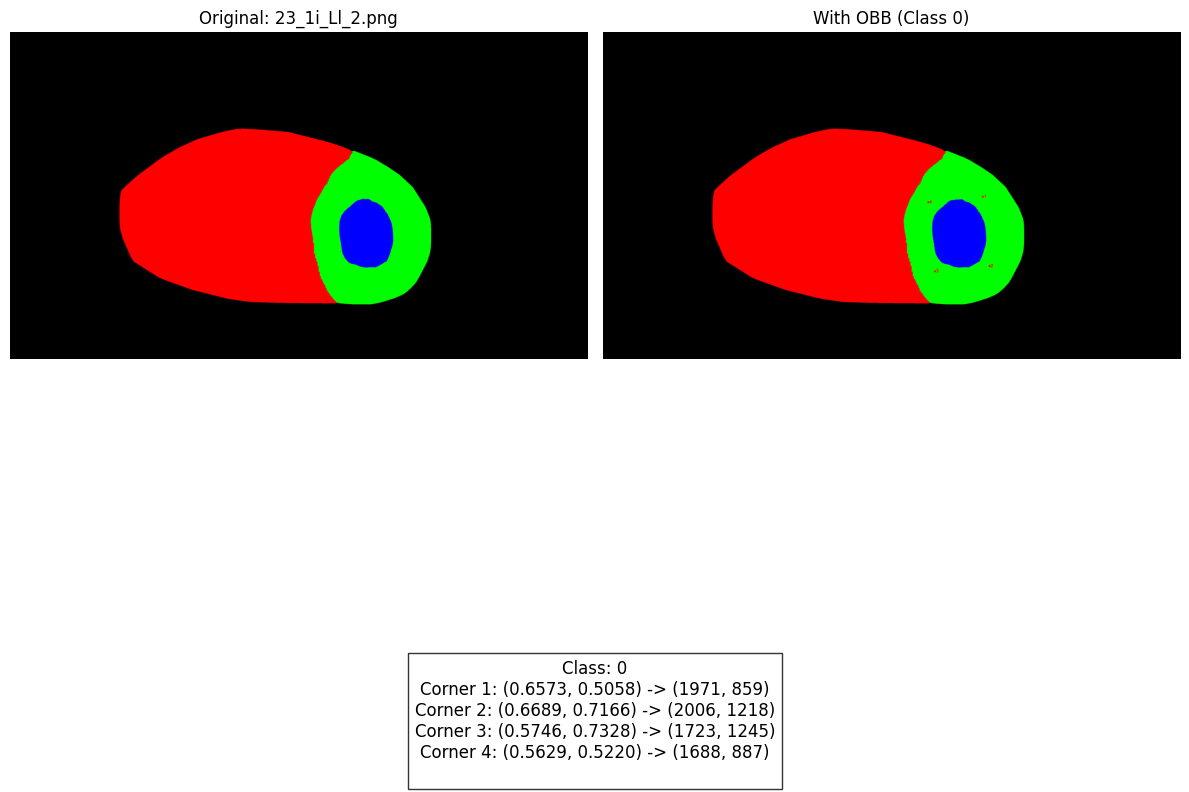

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import argparse

def read_obb_label(label_path):
    """
    YOLOのOBBラベルファイルを読み込む関数
    
    Parameters:
    -----------
    label_path : str
        ラベルファイルのパス
        
    Returns:
    --------
    list or None
        OBBの情報 [class_id, [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]]
        ファイルが存在しない場合はNone
    """
    if not os.path.exists(label_path):
        print(f"ラベルファイルが見つかりません: {label_path}")
        return None
    
    try:
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split()
            
            if len(parts) != 9:  # クラス + 4つの点の座標(x,y)
                print(f"ラベルのフォーマットが不正です: {label_path}")
                return None
            
            class_id = int(parts[0])
            corners = [
                (float(parts[1]), float(parts[2])),
                (float(parts[3]), float(parts[4])),
                (float(parts[5]), float(parts[6])),
                (float(parts[7]), float(parts[8]))
            ]
            
            return [class_id, corners]
    
    except Exception as e:
        print(f"ラベルの読み込みエラー ({label_path}): {str(e)}")
        return None

def visualize_image_with_obb(image_path, label_path):
    """
    画像とOBBラベルを表示する関数
    
    Parameters:
    -----------
    image_path : str
        画像ファイルのパス
    label_path : str
        ラベルファイルのパス
        
    Returns:
    --------
    bool
        成功した場合はTrue、失敗した場合はFalse
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"画像が読み込めませんでした: {image_path}")
        return False
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    
    obb_data = read_obb_label(label_path)
    if obb_data is None:
        print(f"ラベルが読み込めないか、不正なフォーマットです: {label_path}")
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title(f'Image: {os.path.basename(image_path)}\nNo valid label found')
        plt.axis('off')
        plt.show()
        return False
    
    class_id, norm_corners = obb_data
    
    corners = []
    for x, y in norm_corners:
        corners.append((int(x * width), int(y * height)))
    
    visual_img = img_rgb.copy()
    
    corners_array = np.array(corners, dtype=np.int32)
    cv2.polylines(visual_img, [corners_array], True, (0, 255, 0), 2)
    
    for i, (x, y) in enumerate(corners):
        cv2.circle(visual_img, (x, y), 5, (255, 0, 0), -1)
        cv2.putText(visual_img, str(i+1), (x+5, y+5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f'Original: {os.path.basename(image_path)}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(visual_img)
    plt.title(f'With OBB (Class {class_id})')
    plt.axis('off')
    
    label_text = f"Class: {class_id}\n"
    for i, (nx, ny) in enumerate(norm_corners):
        label_text += f"Corner {i+1}: ({nx:.4f}, {ny:.4f}) -> ({corners[i][0]}, {corners[i][1]})\n"
    
    plt.figtext(0.5, 0.01, label_text, ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()
    
    return True

def find_corresponding_label(image_path, label_dir):
    """
    画像に対応するラベルファイルを見つける関数
    
    Parameters:
    -----------
    image_path : str
        画像ファイルのパス
    label_dir : str
        ラベルディレクトリのパス
        
    Returns:
    --------
    str or None
        対応するラベルファイルのパス、見つからない場合はNone
    """
    # 画像のファイル名（拡張子なし）を取得
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # 対応するラベルファイルのパスを作成
    label_path = os.path.join(label_dir, base_name + '.txt')
    
    if os.path.exists(label_path):
        return label_path
    else:
        print(f"対応するラベルファイルが見つかりません: {base_name}")
        return None

# メイン実行部分
if __name__ == "__main__":
    image_path = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\MOBIUS\Masks\23\23_1i_Ll_2.png"

    label_path = r"C:\Users\CorneAI\YOLOv11_modified_Mobius\labels\23_1i_Ll_2.txt"
    visualize_image_with_obb(image_path, label_path)